# 平均分散アプローチによるポートフォリオ選択

平均分散アプローチ
- 11952年に、マーコヴィッツ氏によって提唱された資産運用における個別資産への投資分配を決定するための方法

ポートフォリオ
- 投資家が保有する資産の種類と数量を組み合わせたもの

最適ポートフォリオ
- 何らかの基準に照らし合わせて「もっとも得をする」資産保有の方法

最適ポートフォリオを見つける方法としては以下の順
- 資産運用の方法を数式を使って表現する
- その後、平均分散アプローチを導入する


資産運用の開始を0、終了を1とするとし、0時点での投資家の手持ち資金をw(0)と表す。

この手持ち資金はN個の資産に分散するため、0における資産nの市場価格をXn(0)とし、1の時はXn(1)とする

また、0から1にかけて受け取る配当や利子をdnとすると資産の収益率は、


このとき、Xn(1)やdnは不確実であるため、Rnは確率変数であるとわかる。

そこでRnの平均と分散はそれぞれ
$$ E[Rn] = \mu n $$
$$ Var[Rn] = \sigma ^2 n $$

と仮定する

$$ \mu n $$

は資産nの期待収益率と呼ばれる

さらに収益率の間の共分散を$$Cov[Rn,Rm] = \sigma nm $$とする

ここで収益率のベクトルを

$$
R =  \left[
\begin{matrix} 
R_{1} \\ 

：\\

R_{N} \\
\end{matrix}

\right]
$$

と定義すると

Rの平均ベクトルと、分散共分散行列は以下のようになる

- 平均ベクトル
$$
\mu =  \left[
\begin{matrix} 
\mu _{1} \\ 
：\\
\mu _{N} \\
\end{matrix}

\right]
$$

- 分散共分散行列
$$
\sum =  \left[
\begin{matrix} 
\sigma^2 _{1} ... \sigma _{1N} \\ 
：\\
\sigma _{N1} ... \sigma^2 _{N} \\
\end{matrix}

\right]
$$


資産nの購入単位数を$$a_{n}$$とすると、時点0におけるポートフォリオの価値w(0)と、時点1におけるポートフォリオの価値W(1)はそれぞれ、

$$

W(0) = \sum ^{N}_{n=1} a_{n}X_{n}(0) \\

W(1) = \sum ^{N}_{n=1} a_{n}(X_{n}(1) + d_{n})

$$

と表される


よって、ポートフォリオの収益率

$$
R_{p}
$$

は運用期間内でのポートフォリオの価値の変化率

$$
R_{p} = \frac{W(1)-W(0)}{W(0)} \\
\\
= \frac{\sum ^{N}_{n = 1} {a_{n}(X_{n}(1) + d_{n})}}{W(0)} \\
\\
= \frac{\sum ^{N}_{n = 1} {a_{n}X_{n}(0)}}{W(0)} * R_{n} \\
$$

として定義される

### 注：マークダウンで数式を書いていくのはタイパが悪い。別の方法を探す

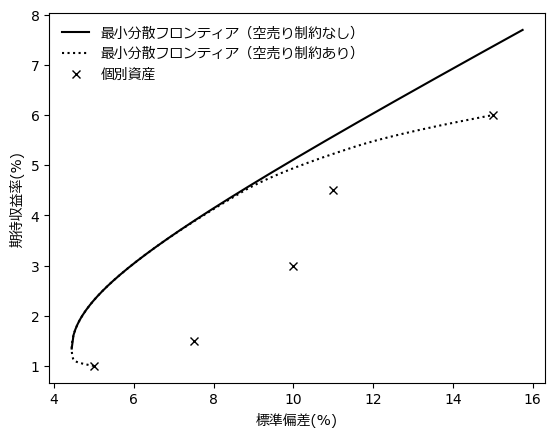

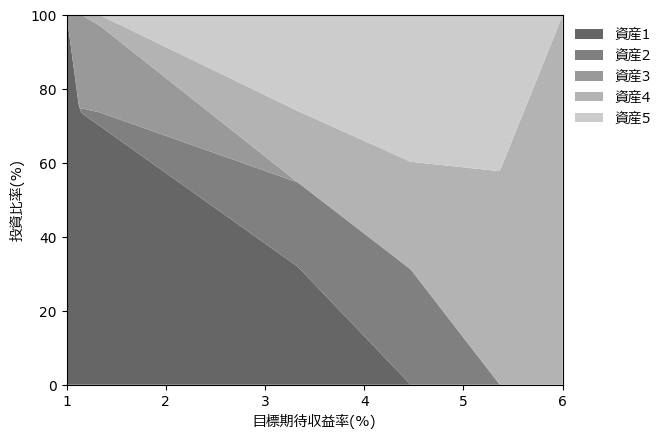

In [1]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   NumPyのLinalgモジュールの読み込み
import numpy.linalg as lin
#   CVXPYの読み込み
import cvxpy as cvx
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
jpfont = FontProperties(fname=FontPath)
#%% 最小分散ポートフォリオの計算
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev).dot(CorrMatrix).dot(np.diag(Stdev))
iota = np.ones(Mu.shape)
inv_Sigma = lin.inv(Sigma)
A = Mu.dot(inv_Sigma).dot(iota)
B = Mu.dot(inv_Sigma).dot(Mu)
C = iota.dot(inv_Sigma).dot(iota)
D = B * C - A ** 2
#%% 空売り制約の下での分散最小化問題の設定
Weight = cvx.Variable(Mu.shape[0])
Target_Return = cvx.Parameter(nonneg=True)  # 正の値のみ許容する場合
Risk_Variance = cvx.quad_form(Weight, Sigma)
Opt_Portfolio = cvx.Problem(
    cvx.Minimize(Risk_Variance),  # リスク（分散）を最小化
    [
        Weight.T @ Mu == Target_Return,         # 制約1: 目標リターンを満たす
        cvx.sum(Weight) == 1.0,                 # 制約2: 重みの合計が1
        Weight >= 0.0                           # 制約3: ショートセール（負の重み）は許可しない
    ]
)

#%% 空売り制約の下での最小分散フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
V_Weight = np.zeros((V_Target.shape[0], Mu.shape[0]))
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve()
    V_Weight[idx, :] = Weight.value.T
    V_Risk[idx] = np.sqrt(Risk_Variance.value)
#%% 最小分散フロンティアの作図
sigma_gmv = 1.0 / np.sqrt(C)
sigma_p = np.linspace(sigma_gmv, 1.05 * np.max(Stdev), num=250)
mu_p_efficient = (A + np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C
fig1 = plt.figure(1, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'k-')
plt.plot(V_Risk, V_Target, 'k:')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'kx')
plt.legend([u'最小分散フロンティア（空売り制約なし）',
            u'最小分散フロンティア（空売り制約あり）',
            u'個別資産'],
           loc='best',  frameon=False, prop=jpfont)
plt.xlabel(u'標準偏差(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
#   投資比率の推移の作図
fig2 = plt.figure(2, facecolor='w')
plt.stackplot(V_Target, V_Weight.T*100,
              colors=tuple([tuple(gray*np.ones(3))
                            for gray in np.linspace(0.4, 0.8, num=Mu.shape[0])
                            ]))
plt.axis([Mu.min(), Mu.max(), 0.0, 100.0])
plt.legend([u'資産1', u'資産2', u'資産3', u'資産4', u'資産5'],
           loc='upper left', bbox_to_anchor=(1.0, 1.0),
           frameon=False, prop=jpfont)
plt.xlabel(u'目標期待収益率(%)', fontproperties=jpfont)
plt.ylabel(u'投資比率(%)', fontproperties=jpfont)
plt.show()

# 期待収益率と収益率の分散共分散行列が未知の場合

多変量正規分布からの資産収益率データの生成

In [2]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   SciPyのstatsモジュールの読み込み
import scipy.stats as st
#   Pandasの読み込み
import pandas as pd
#%% 多変量正規分布からの乱数生成と保存
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev).dot(CorrMatrix).dot(np.diag(Stdev))
np.random.seed(9999)
T = 120
End_of_Month = pd.date_range('1/1/2007', periods=T, freq='M')
Asset_Names = [u'資産1', u'資産2', u'資産3', u'資産4', u'資産5']
Asset_Return = pd.DataFrame(st.multivariate_normal(Mu, Sigma).rvs(T),
                            index=End_of_Month, columns=Asset_Names)
Asset_Return.to_csv('20250124a_1_asset_return_data.csv')

C:\Users\20222305\AppData\Local\Temp\ipykernel_17964\3794216151.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  End_of_Month = pd.date_range('1/1/2007', periods=T, freq='M')


期待収益率と収益率の分散共分散行列をデータから推定する場合の最適化

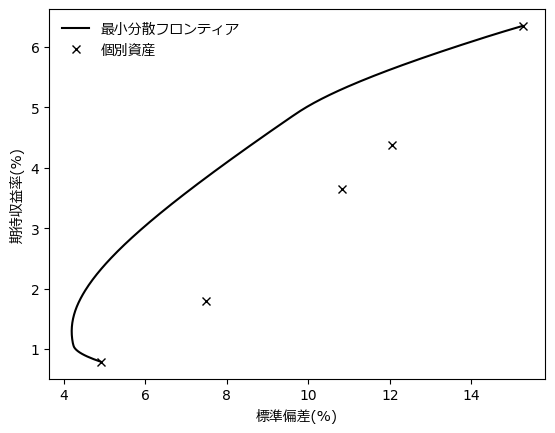

In [3]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   CVXPYの読み込み
import cvxpy as cvx
#   Pandasの読み込み
import pandas as pd
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
jpfont = FontProperties(fname=FontPath)

#%% 収益率データの読み込み
R = pd.read_csv('20250124a_1_asset_return_data.csv', index_col=0)
T = R.shape[0]
N = R.shape[1]
Mu = R.mean().values
Sigma = R.cov().values * ((T - 1.0) / T)
Return_Dev = (R - Mu).values / np.sqrt(T)

#%% 空売り制約の下での分散最小化問題の設定
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
Target_Return = cvx.Parameter(nonneg=True)  # 正の値のみ許容する場合
Risk_Variance = cvx.sum_squares(Deviation)

# 最適化問題の定義
Opt_Portfolio = cvx.Problem(
    cvx.Minimize(Risk_Variance),  # リスク（分散）を最小化
    [
        Return_Dev @ Weight == Deviation,      # 制約1: 許容偏差を満たす
        Weight.T @ Mu == Target_Return,        # 制約2: 目標リターンを達成
        cvx.sum(Weight) == 1.0,                # 制約3: 重みの合計が1
        Weight >= 0.0                          # 制約4: 重みは非負
    ]
)

#%% 空売り制約の下での最小分散フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)

for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve()
    V_Risk[idx] = np.sqrt(Risk_Variance.value)

#%% 最小分散フロンティアのグラフの作成
fig1 = plt.figure(1, facecolor='w')
plt.plot(V_Risk, V_Target, 'k-')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'kx')
plt.legend([u'最小分散フロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'標準偏差(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()